In [153]:
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as img
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [154]:
data_dir = Path('/home/ylytkin/Development/data/camera_relocalization_sample_dataset')
images_dir = data_dir / 'images'

In [155]:
info = pd.read_csv(data_dir / 'info.csv').reset_index(drop=True)
info.head()

,Unnamed: 0,Unnamed: 0.1,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,IMU_LAX,IMU_LAY,IMU_LAZ,IMU_AVX,IMU_AVY,IMU_AVZ,ImageFile,DepthFile,SegFile
0,0,0,1542098918672,1.628652,-1.342870,-0.038781,1.000000,-0.0,0.0,0.000000,-0.012323,0.012355,-9.793530,0.000031,0.000238,0.000235,img_0_0_1542098919031247900.png,img_0_3_1542098919034924900.png,img_0_5_1542098919037481300.png
1,1,1,1542098927672,0.539220,-0.753961,-0.038781,0.219876,-0.0,0.0,0.975528,-0.004269,-0.007061,-9.796641,-0.000113,0.000299,0.000157,img_0_0_1542098928056216200.png,img_0_3_1542098928058906700.png,img_0_5_1542098928061151600.png
2,2,2,1542099006672,1.811826,-1.783541,-0.038781,0.845706,-0.0,0.0,0.533649,0.007127,-0.006138,-9.802512,0.000018,0.000242,-2.073797,img_0_0_1542099007064132600.png,img_0_3_1542099007066469000.png,img_0_5_1542099007068223000.png
3,3,3,1542099035673,1.735275,0.055900,-0.038781,0.988930,-0.0,0.0,0.148384,4.352539,3.855151,-9.808618,-0.000499,-0.000436,-1.609914,img_0_0_1542099036029939100.png,img_0_3_1542099036032202400.png,img_0_5_1542099036034012000.png
4,4,4,1542099047673,-1.467342,-0.783857,-0.038781,0.127870,0.0,-0.0,-0.991791,0.001481,-0.007924,-9.816813,0.000579,0.000273,-0.000102,img_0_0_1542099048061266300.png,img_0_3_1542099048063828800.png,img_0_5_1542099048066488000.png


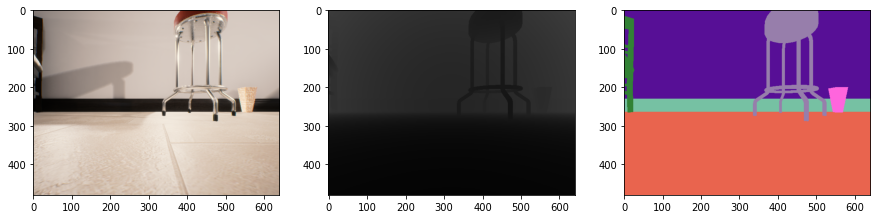

In [160]:
fig, axes = plt.subplots(ncols=3)
fig.set_size_inches(15, 5)

for fname, ax in zip(info.loc[0, ['ImageFile', 'DepthFile', 'SegFile']], axes.flatten()):
    fpath = images_dir / fname
    ax.imshow(img.imread(fpath))

In [199]:
images = np.array([img.imread(images_dir / fname) for fname in tqdm(info['ImageFile'])])
images.shape

(1000, 480, 640, 4)

In [200]:
x = images[:, ::2, ::2, :-1].copy()
x.shape

(1000, 240, 320, 3)

In [201]:
y = info[['POS_X', 'POS_Y', 'POS_Z', 'Q_W', 'Q_X', 'Q_Y', 'Q_Z']].values.astype(np.float64)
y.shape

(1000, 7)

In [202]:
cropped_size = 180

In [203]:
def get_random_crop(image: np.ndarray, cropped_size: int) -> np.ndarray:
    height, width, _ = image.shape
    top_left_x = np.random.randint(0, height - cropped_size)
    top_left_y = np.random.randint(0, width - cropped_size)
    
    return image[top_left_x:top_left_x+cropped_size, top_left_y:top_left_y+cropped_size]

def get_center_crop(image: np.ndarray, cropped_size: int) -> np.ndarray:
    height, width, _ = image.shape
    top_left_x = (height - cropped_size) // 2
    top_left_y = (width - cropped_size) // 2
    
    return image[top_left_x:top_left_x+cropped_size, top_left_y:top_left_y+cropped_size]

In [204]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [205]:
x_train_augmented = []
y_train_augmented = []

for x_, y_ in zip(x_train, y_train):
    for _ in range(20):
        x_train_augmented.append(get_random_crop(x_, cropped_size=cropped_size))
        y_train_augmented.append(y_)
        
x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)

x_train_augmented.shape, y_train_augmented.shape

((16000, 180, 180, 3), (16000, 7))

In [206]:
x_test_centered = np.array([get_center_crop(image, cropped_size=cropped_size) for image in x_test])

x_test_centered.shape, y_test.shape

((200, 180, 180, 3), (200, 7))

In [207]:
def loss_(y_true, y_pred, beta: float):
    y_true_pos = y_true[:, :4]
    y_true_q = y_true[:, 4:]
    y_pred_pos = y_pred[:, :4]
    y_pred_q = y_pred[:, 4:]
    
    return (tf.reduce_sum(tf.square(y_true_pos - y_pred_pos), axis=1)
            + beta * tf.reduce_sum(tf.square(y_true_q - y_pred_q), axis=1))

In [208]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=x_train_augmented[0].shape),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train_augmented.shape[1]),
])

In [213]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 25600)           

In [211]:
model.compile(loss=lambda y_true, y_pred: loss(y_true, y_pred, beta=250), metrics=['mse'])

In [262]:
hist = model.fit(x_train_augmented, y_train_augmented, epochs=1, validation_data=[x_test_centered, y_test])

Train on 16000 samples, validate on 200 samples
16000/16000 [==============================] - 77s 5ms/sample - loss: 14.7250 - mse: 0.1622 - val_loss: 13.6785 - val_mse: 0.1157


In [268]:
hist.history

{'loss': [14.725023195266724],
 'mse': [0.16220355],
 'val_loss': [13.678495788574219],
 'val_mse': [0.11570039]}

In [263]:
dir(hist)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_keras_api_names',
 '_keras_api_names_v1',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [261]:
dir(model)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_inbound_node',
 '_add_trackable',
 '_add_unique_metric_name',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_attribute_sentinel',
 '_autocast',
 '_base_init',
 '_build_input_shape',
 '_build_model_with_inputs',
 '_cache_output_metric_attributes',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_check_call_args',
 '_check_trainable_weights_consistency',
 '_checkpoint_dependencies',
 '_clear_losse

In [255]:
y_pred = model.predict(x_test_centered)
y_pred[:, 4:] /= ((y_pred[:, 4:] ** 2).sum(axis=1) ** 0.5).reshape(-1, 1)

In [257]:
tf.keras.metrics.mse(y_test, y_pred).numpy().mean()

0.22462025

In [260]:
loss(y_test, y_pred, beta=250).numpy().mean()

121.51570013533313

In [241]:
tf.reduce_mean(tf.keras.metrics.mse(y_test, y_pred))

<tf.Tensor: shape=(), dtype=float32, numpy=0.22462021>

In [218]:
y_test[0]

array([-1.125278, -1.213737, -0.038781,  0.973839, -0.      ,  0.      ,
        0.227238])

In [219]:
y_pred[0]

array([-1.2595739e+00, -1.3276528e+00, -3.2645985e-02,  8.8818407e-01,
        1.1993269e-03, -1.2445042e-02,  9.5870920e-02], dtype=float32)

In [91]:
y_pred = model.predict(x_test)

In [92]:
y_test[0]

array([ 1.192252, -1.017841, -0.038781,  0.956864,  0.      , -0.      ,
       -0.290536])

In [93]:
y_pred[0]

array([ 1.3645828 , -0.507827  , -0.06405304,  0.91818684, -0.01238632,
        0.01091536, -0.40198877], dtype=float32)